In [2]:
# This notebook contains code for evalating the diminishing returns design against
# prior designs (Figure 3)

In [3]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import gzip

from copy import deepcopy
from matplotlib import pyplot as plt
import Levenshtein as lev

import torch
from torch.nn import parallel

<h3>Import Data</h3>

In [4]:
with open("./data.pkl", 'rb') as fin:
    mhc1_data, mhc2_data = pickle.load(fin)

In [6]:
# Script for processing data

def makeProductDistribution(population, dataset):
    _,alleles,_ = dataset
    intmap = {}
    for i,allele in enumerate(alleles):
        intmap[allele] = i
    default = len(alleles)
    population = [(frozenset([intmap.get(x[1], default) for x in genotype]),p) for genotype, p in population]
    diploidDistribution = {}
    for i,(haplotype1,p1) in tqdm(enumerate(population), position = 0, leave = True):
        if haplotype1 not in diploidDistribution:
            diploidDistribution[haplotype1] = 0
        diploidDistribution[haplotype1] += p1 ** 2
        for (haplotype2,p2) in population[:i]:
            diplotype = haplotype1.union(haplotype2)
            if diplotype not in diploidDistribution:
                diploidDistribution[diplotype] = 0
            diploidDistribution[diplotype] += 2 * p1 * p2
    return diploidDistribution
    
def makeDiploidDistribution(populations, dataset):
    default = len(dataset[1])
    distributions = [makeProductDistribution(population, dataset) for population in populations]
    for distribution in distributions[1:]:
        for genotype in distribution:
            if genotype not in distributions[0]:
                distributions[0][genotype] = distribution[genotype]
            else:
                distributions[0][genotype] += distribution[genotype]
    distribution = distributions[0]
    indexes = []
    weights = []
    for genotype in distribution:
        weights.append( distribution[genotype]/3 )
        genotype = tuple(genotype)
        if len(genotype) != 6:
            genotype = genotype + ( (default,) * (6-len(genotype)) )
        indexes.append(genotype)
    indexes = np.array(indexes, dtype = np.int16)
    weights = np.array(weights)
    return indexes, weights
    
def reformatData(data):
    credence_data, _, _, population = data
    
    credence_distribution = makeDiploidDistribution(population, credence_data)
    credence_data = torch.tensor(1-credence_data[0], dtype = torch.float32), credence_data[2],\
        credence_distribution[0], torch.tensor(credence_distribution[1], dtype = torch.float32)
    
    print (credence_data[0].size())
    return credence_data

inputs1_credences = reformatData(mhc1_data)
inputs2_credences = reformatData(mhc2_data)

779it [00:00, 929.25it/s] 
1200it [00:02, 550.79it/s]
440it [00:00, 2962.11it/s]
128it [00:00, 366.72it/s]

torch.Size([1195, 298])


537it [00:00, 1004.62it/s]
920it [00:01, 636.28it/s]
502it [00:00, 2767.39it/s]


torch.Size([4082, 281])


<h3>Evaluation algorithm</h3>

In [7]:
# Utility functions

# f(x) = min(n, x)
def getThresholdUtility(n):
    return torch.tensor(np.arange(0,n+1,1),dtype = torch.float32)

def getMarginalImprovement(utility):
    return torch.cat( (utility[1:] - utility[:-1], torch.zeros(1)) )

def getMultiUtility(utilities):
    maxlength = max([z.size(dim = 0) for z in utilities])
    allUtilities = []
    for utility in utilities:
        extendedUtil = torch.ones(maxlength, dtype = utility.dtype) * utility[-1]
        extendedUtil[:utility.size(dim = 0)] = utility
        allUtilities.append(extendedUtil)
    return torch.stack(allUtilities)

def dedupe_designs(seqs):
    seen = set()
    seqs2 = []
    for seq in seqs:
        if seq not in seen: seqs2.append(seq)
        seen.add(seq)
    return seqs2

def data_to_cuda(data):
    candidates, seqs, columnIndex, columnWeights = data
    return candidates.cuda(), seqs, columnIndex, columnWeights.cuda()

In [8]:
#candidates: [candidate, 1 - pMHC hit probability]
#columnIndex: [diplotype, allele in diplotype]
#columnWeights: [diplotype]
#distributions: [dummy, diplotype, distribution]
#marginalImprovement: [improvement (shifting from i to i+1, so last entry should be 0)]

def evaluateCandidates(candidates, columnIndex, columnWeights, distributions, marginalImprovement):
    probabilityOfHit = 1 - torch.prod(candidates[:, columnIndex], dim = 2).unsqueeze(2)
    shiftedMass = distributions * probabilityOfHit
    improvement = torch.sum( shiftedMass * marginalImprovement, dim = 2)
    weightedImprovement = torch.sum( improvement * columnWeights, dim = 1)
    return weightedImprovement

def updateDistribution(newRow, columnIndex, distributions):
    probabilityOfMiss = torch.prod(newRow[columnIndex], dim = 1).reshape(1, -1, 1)
    shiftedMass = distributions * (1-probabilityOfMiss)
    
    convolution = distributions * probabilityOfMiss
    convolution[:,:,1:] += shiftedMass[:,:,:-1]
    convolution[:,:,-1] += shiftedMass[:,:,-1]
    return convolution

def evaluateDesign(candidates, seqs, columnIndex, columnWeights, design, utility):
    design = dedupe_designs(design)
    distributions = torch.zeros( (1, len(columnIndex), len(utility)) )
    distributions[:, :, 0] = 1
    
    seqToIndex = {}
    for i, seq in enumerate(seqs):
        seqToIndex[seq] = i
        
    for seq in design:
        if seq not in seqToIndex: continue
        row = seqToIndex[seq]
        distributions = updateDistribution(candidates[row], columnIndex, distributions)
        
    scores = torch.sum( distributions * utility.view(1,1,-1), dim = 2 ).reshape(-1)
    return torch.sum(scores * columnWeights).item()

def evaluateDesignTrajectory(candidates, seqs, columnIndex, columnWeights, design, utility):
    design = dedupe_designs(design)
    distributions = torch.zeros( (1, len(columnIndex), len(utility)) )
    distributions[:, :, 0] = 1
    
    seqToIndex = {}
    for i, seq in enumerate(seqs):
        seqToIndex[seq] = i
        
    scores = []
    for seq in design:
        row = seqToIndex[seq]
        distributions = updateDistribution(candidates[row], columnIndex, distributions)
        currentScores = torch.sum( distributions * utility.view(1,1,-1), dim = 2 ).reshape(-1)
        scores.append(torch.sum(currentScores * columnWeights).item())
        
    return scores

def evaluateDesignTrajectoryMultiUtility_cpu(candidates, seqs, columnIndex, columnWeights, design, utility):
    design = dedupe_designs(design)
    distributions = torch.zeros( (1, len(columnIndex), utility.size(dim = 1) ) )
    distributions[:, :, 0] = 1
    
    seqToIndex = {}
    for i, seq in enumerate(seqs):
        seqToIndex[seq] = i
        
    scores = []
    for seq in tqdm(design, position = 0, leave = True):
        row = seqToIndex[seq]
        distributions = updateDistribution(candidates[row], columnIndex, distributions)
        currentScores = torch.sum(
            distributions.unsqueeze(0) * utility.view(utility.size(dim=0),1,1,utility.size(dim=1)), dim = 3 ).squeeze(1)
        scores.append(torch.sum(currentScores * columnWeights.view(1,-1), dim = 1).numpy())
        
    return scores

def evaluateDesignTrajectoryMultiUtility(candidates, seqs, columnIndex, columnWeights, design, utility):
    design = dedupe_designs(design)
    distributions = torch.zeros( (1, len(columnIndex), utility.size(dim = 1) ) ).cuda()
    distributions[:, :, 0] = 1
    
    seqToIndex = {}
    for i, seq in enumerate(seqs):
        seqToIndex[seq] = i
        
    scores = []
    for seq in design:
        row = seqToIndex[seq]
        distributions = updateDistribution(candidates[row], columnIndex, distributions)
        currentScores = torch.sum(
            distributions.unsqueeze(0) * utility.view(utility.size(dim=0),1,1,utility.size(dim=1)), dim = 3 ).squeeze(1)
        scores.append(torch.sum(currentScores * columnWeights.view(1,-1), dim = 1).cpu().numpy())
        
    scores = np.array(scores).T
    return scores

<h3>Analysis</h3>

In [9]:
credence1 = []
binarized1 = []
credence2 = []
binarized2 = []
for threshold in range(1, 21):
    with open("./outputs/mhc1_credences_threshold_{}.pkl".format(threshold), 'rb') as fin:
        credence1.append(pickle.load(fin))
    with open("./outputs/mhc2_credences_threshold_{}.pkl".format(threshold), 'rb') as fin:
        credence2.append(pickle.load(fin))
        
with open("./benchmarks.pkl", 'rb') as fin:
    benchmark_trajectories, benchmark_designs = pickle.load(fin)

In [ ]:
benchmark_designs_scores = {}
for design in tqdm(benchmark_designs, position = 0, leave = True):
    if "MHC1" in design:
        data = inputs1_credences
    elif "MHC2" in design:
        data = inputs2_credences
    else:
        raise Exception("Unknown MHC Class")
    scores = [evaluateDesign(*data,benchmark_designs[design],getThresholdUtility(evaluate_threshold)) for
                 evaluate_threshold in range(1,21)]
    benchmark_designs_scores[design] = scores
    
benchmark_trajectories_scores = {}
for design in benchmark_trajectories:
    if "MHC1" in design:
        data = inputs1_credences
    elif "MHC2" in design:
        data = inputs2_credences
    else:
        raise Exception("Unknown MHC Class")
        
    trajectory = benchmark_trajectories[design]
    trajectoryScores = {}
    for designSize in tqdm(trajectory, position = 0, leave = True):
        scores = [evaluateDesign(*data,trajectory[designSize],getThresholdUtility(evaluate_threshold)) for
                     evaluate_threshold in range(1,21)]
        trajectoryScores[designSize] = scores
    benchmark_trajectories_scores[design] = trajectoryScores

In [ ]:
def getAllTrajectories(designs, data):
    trajectories = [[[] for i in range(20)] for j in range(20)]
    with tqdm(position = 0, leave = True) as pbar:
        for design_threshold, design in enumerate(designs, 1):
            for evaluate_threshold in range(1,21):
                trajectories[design_threshold-1][evaluate_threshold-1] =\
                    evaluateDesignTrajectory(*data,design, getThresholdUtility(evaluate_threshold))
                pbar.update(1)
    return trajectories

mhc1_design_scores = getAllTrajectories(credence1, inputs1_credences)
mhc2_design_scores = getAllTrajectories(credence2, inputs2_credences)

In [ ]:
def getSelectablePeptides(data):
    _, _, peptides = data[0]
    filtered = sorted(list( set(data[2]).intersection(set(peptides)) ))
    print (len(filtered))
    return filtered

def calculateRandomTrajectories(candidates, size, rng, data, utility, iterations):
    data = data_to_cuda(data)
    utility = utility.cuda()
    scores = []
    for _ in tqdm(range(iterations), position = 0, leave = True):
        randomTrajectory = [candidates[i] for i in rng.permutation(len(candidates))[:size]]
        scores.append( evaluateDesignTrajectoryMultiUtility(*data, randomTrajectory, utility) )
    return scores

mhc1_candidates = getSelectablePeptides(mhc1_data)
mhc2_candidates = getSelectablePeptides(mhc2_data)

rng_mhc1 = np.random.RandomState(1054969295)
random_scores1 = calculateRandomTrajectories(mhc1_candidates, 151, rng_mhc1,
                            inputs1_credences, getMultiUtility([getThresholdUtility(z) for z in range(1,21)]), 1000)

rng_mhc2 = np.random.RandomState(1800457161)
random_scores2 = calculateRandomTrajectories(mhc2_candidates, 151, rng_mhc2,
                            inputs2_credences, getMultiUtility([getThresholdUtility(z) for z in range(1,21)]), 1000)

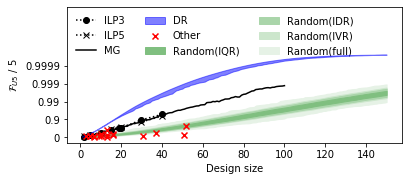

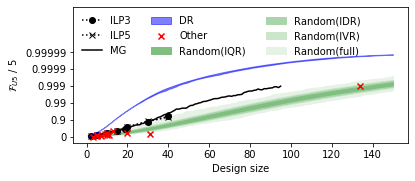

In [33]:
# This block of code was used for generating Figure 3. viewDesignSizesUpTo can be adjusted to zoom
# in on lower x values, and evaluationThreshold can be adjusted to change which evaluation function
# is used to plot the y position. For additional analysis, benchmark_designs_scores, benchmark_trajectories_scores
# mhc1_design_scores, mhc2_design_scores, random_scores1, and random_scores2 contain all necessary data
# from the experiment

# benchmark_designs_scores is a dictionary that maps from a previous design (indicated by a string
# denoting the source of the design and the MHC class it is for) to a utility score array.
# The ith entry (zero indexed) of the array contains the score evaluated by $\mathcal{F}_{U_{i+1}}$.

# benchmark_trajectories_scores is a dictionary of dictionaries. The first index indicates a design
# strategy from Liu et al., while the second index indicates the size of the design. The value mapped
# to by the keys is a a utility score array.

# mhc1_design_scores, and mhc2_design_scores are multidimensional lists. The entry in [i][j][k] denotes
# the score evaluated by the objective $\mathcal{F}_{U_{j+1}}$ of a design of size k that was optimized
# via the diminishing returns framework with the objective by $\mathcal{F}_{U_{i+1}}$.

# random_scores1 and random_scores2 are multidimensional lists. The entry in [i][j][k] denotes
# the score evaluated by the objective $\mathcal{F}_{U_{j+1}}$ of a design of size k. i indexes the random
# samples.



# threshold is off by 1 (set threshold to 2 if we want min(n,3))
def sortOut(benchmark_designs_scores,
            benchmark_designs, benchmark_trajectories_scores, mhccode, design_scores, traj, threshold, xmax):
    fc = lambda x : -np.log( 1-(x/(threshold+1)) )/np.log(10)
    n = xmax
    benchmark_designs_points = {}
    for k in benchmark_designs_scores:
        if mhccode in k:
            benchmark_designs_points[k.split(mhccode + '_')[1]] = (
                len(benchmark_designs[k]), fc(benchmark_designs_scores[k][threshold]))
    benchmark_trajectories_curves = {}
    for k in benchmark_trajectories_scores:
        if mhccode in k:
            xs = []
            ys = []
            for i in range(1,n+1):
                if i in benchmark_trajectories_scores[k]:
                    xs.append(i)
                    ys.append(benchmark_trajectories_scores[k][i][threshold])
            benchmark_trajectories_curves[k.split('_' + mhccode)[0]] = (np.array(xs), fc(np.array(ys)))
    
    diminishingReturns = [ (np.arange(1,n+1,1), fc(np.array(design_scores[z][threshold][:n]))) for z in range(20)]
    random = np.sort( np.array( [tr[threshold][:n] for tr in traj] ), axis = 0 )
    random = fc(random)
    q1 = random.shape[0]//4
    q2 = random.shape[0]//10
    q3 = random.shape[0]//20
    
    _, ax = plt.subplots(1,1, figsize = (6,2.5))
    ax.plot(*benchmark_trajectories_curves["ILP_n3"], linestyle = ':', marker = 'o', label = "ILP3", color = "black")
    ax.plot(*benchmark_trajectories_curves["ILP_n5"], linestyle = ':', marker = 'x', label = "ILP5", color = "black")
    ax.plot(*benchmark_trajectories_curves["MarginalGreedy"], label = "MG", color = "black")
            
    dr_distr = np.array([z[1] for z in diminishingReturns]).T
    ax.fill_between(np.arange(1,n+1,1), np.max(dr_distr, axis = 1), np.min(dr_distr, axis = 1),
                    color = "blue", label = "DR", alpha = 0.5, linewidth = 1, zorder = 10)
    
    pts = np.array([benchmark_designs_points[k] for k in benchmark_designs_points]).T
    ax.scatter(*pts, marker = 'x', color = "red", zorder = 10, label = "Other")
    
    col = np.array([1,0.5,1])
    ax.fill_between(np.arange(1,n+1,1), random[q1], random[-q1],
                    zorder = -5, color = 1-col*0.5, label = "Random(IQR)")
    ax.fill_between(np.arange(1,n+1,1), random[q2], random[-q2],
                    zorder = -6, color = 1-col*(1/3), label = "Random(IDR)")
    ax.fill_between(np.arange(1,n+1,1), random[q3], random[-q3],
                    zorder = -7, color = 1-col*(0.2), label = "Random(IVR)")
    ax.fill_between(np.arange(1,n+1,1), random[1], random[-1],
                    zorder = -8, color = 1-col*(0.1), label = "Random(full)")
    
    ticks = np.arange(0,ax.get_ylim()[1],1)
    ax.set_yticks(ticks)
    ax.set_yticklabels(["0"] + ["0." + ('9'*int(x)) for x in ticks[1:]])
    ax.legend(ncol = 3, framealpha = 0, loc = "upper left")
    ax.set_xlabel("Design size")
    ax.set_ylabel("$\\mathcal{F}_{U5}$ / 5")
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.5)
    
    plt.show()
    
# Which utility to evaluate against (1-20)
evaluationThreshold = 5

# How far to extend the x axis
viewDesignSizesUpTo = 150

sortOut(benchmark_designs_scores,
        benchmark_designs,
        benchmark_trajectories_scores,
        "MHC1",
        mhc1_design_scores,
        random_scores1,
        evaluationThreshold-1,
        viewDesignSizesUpTo)
sortOut(benchmark_designs_scores,
        benchmark_designs,
        benchmark_trajectories_scores,
        "MHC2",
        mhc2_design_scores,
        random_scores2,
        evaluationThreshold-1,
        viewDesignSizesUpTo)